### Задание: построить нейронную модель для предсказания цен на книги на базе данных https://www.labirint.ru

1. Предобработка данных (считаем, что allPrice в бд лабиринта - это маректинговый ход, заключающийся в намеренном завышении цены с последующей скидкой для роста продаж, поэтому целевым параметром будем считать )
   Идея: чистка данных от пустых значений, преобразование текстовых полей в численные, 

In [14]:
df = pd.read_csv('labirint_dataset.csv', sep=';')

print(df.columns.tolist())

['Unnamed: 0', 'id', 'typeObject', 'groupOfType', 'underGroup', 'genres', 'bookName', 'imgUrl', 'age', 'authors', 'publisher', 'datePublisher', 'series', 'bookGenres', 'allPrice', 'myPrice', 'sale', 'isbn', 'pages', 'pageType', 'weight', 'da', 'db', 'dc', 'covers', 'decoration', 'illustrations', 'rate', 'rateSize', 'annotation']


In [1]:
import pandas as pd
import re
import numpy as np

# Загрузка данных
df = pd.read_csv('labirint_dataset.csv', sep=';')

# Удаление строк с NaN в 'myPrice'
df = df.dropna(subset=['myPrice'])

# Удаление "бесполезных полей" (индексы, ссылки, уникальные номера, аннотация, скидки и полная цена)
df = df.drop(columns=['Unnamed: 0', 'id', 'imgUrl', 'allPrice', 'sale', 'annotation', 'isbn'])

# После анализа поля "Название", было принято решение также дропнуть это поле, так как есть другие параметры, 
# которые учитывают ключевые слова, которые могут влиять на цену
df = df.drop(columns=['bookName'])

# Также незначительным посчитали год издания, так как большее влияние оказываюь специфика производства
df = df.drop(columns=['datePublisher'])

# Значения рейтинга сделаем бинарным (совместимость с моделями ребят из команды)
df['rate'] = df['rate'].fillna(0.0)
df['rate'] = np.where(df['rate'] > 9.25, 1, 0)
df = df.drop(columns=['rateSize'])

# Заменим размеры книг на их объем, введя новый параметр 'volume' (имеет смысл, так как объемные энциклопедии 
# стоят дороже, чем легкие развивашки для детей). Пропуски заполним медианой, т.к. это оптимальный способ

# Заполнение пропущенных значений медианой
df['da'] = df['da'].fillna(df['da'].median())
df['db'] = df['db'].fillna(df['db'].median())
df['dc'] = df['dc'].fillna(df['dc'].median())

# Создание нового признака "объем", мм^3 переведем в см^3
df['volume'] = df['da'] * df['db'] * df['dc'] * 10**(-3)

# Удаление исходных признаков
df = df.drop(columns=['da', 'db', 'dc'])
df['volume'] = df['volume'].round(1)

# Параметр 'weight' зависит от 'volume' через плотность, поэтому они высоко коррелируют, т.е. удаляем
df = df.drop(columns=['weight'])

# Проанализируем процент пропуска для полей
# Поле 'age' пусто на ~67%. Т.к. коэффициент детерминации r2~0.02, то этим полем мы можем пренебречь
df = df.drop(columns=['age'])

# Поле 'bookGenres' пусто на ~76%. Причем количество уникальных значений составляет 707, а так как информация об этом
# параметре содержится в 'underGroup', удаляем его
df = df.drop(columns=['bookGenres'])

# Поле 'decoration' пусто на 70%, однако дорогие материала значительно влияют на цену. Можно проанализировать, какие
# именно декорации являются уникальными. После текстового анализа можно выделить 25 отдельных категорий, каждый из
# которых оказывает значительное влияние на ценообразование. Выделим их, как отдельные бинарные поля
# Заполнение пропусков
df['decoration'] = df['decoration'].fillna('Без декораций').str.lower()

# Функция для создания бинарных признаков
def add_binary_features(df_init, patterns):
    for feature, pattern in patterns.items():
        df_init[feature] = df_init['decoration'].apply(lambda x: 1 if re.search(pattern, x) else 0)
    return df_init

# Паттерны для каждой категории
patterns = {
    # Основные эффекты
    'embossing_gold': r'тиснение золотом',
    'embossing_silver': r'тиснение серебром',
    'embossing_colored': r'тиснение цветное',
    'embossing_volume': r'тиснение объемное',
    'partial_lacquer': r'частичная лакировка',
    'puffy_cover': r'пухлая обложка',

    # Дополнения
    'bookmark_ribbon': r'ляссе',
    'super_cover': r'супер',
    'edge_trim_gold': r'обрез золотой',
    'edge_trim_silver': r'обрез серебряный',
    'edge_trim_colored': r'обрез цветной',
    'slipcase_close': r'футляр закрытый',
    'slipcase_open': r'футляр открытый',
    
    # Функциональные элементы
    'stickers': r'с наклейками',
    'puzzles': r'с пазлами',
    'movable_elements': r'с подвижными элементами',
    'volume_panorama': r'с объемной панорамой',
    'sound_module': r'со звуковым модулем',
    'toy': r'с игрушкой',
    'magnet': r'с магнитами',

    # Специальные покрытия и материалы
    'glitter': r'глиттер',
    'flocking': r'флокинг',
    'soft_touch': r'покрытие софттач',

    # Сложные конструкции
    'cutouts': r'вырубка',
    'textile_inserts': r'текстильные и пластиковые вставки'
}

# Применяем функцию
df = add_binary_features(df, patterns)
df = df.drop(columns=['decoration'])

# Поле 'typeObject' делится либо на книги, либо на книги на ин. языке, поэтому можем упростить до бинарного поля 'foreign language'
df['typeObject'] = df['typeObject'].fillna('Книги')
df['foreign_language'] = (df['typeObject'] == 'Книги на иностранном языке').astype(int)
df = df.drop(columns=['typeObject'])

# Поле 'illustrations' состоит из меток чб, цвет, чб+цвет, без иллюстраций, поэтому также добавим бинарные поля.
# Так как поле 'illustrations' заполнено на ~99.2%, то просто дропнем незаполненные поля
df = df.dropna(subset=['illustrations'])

def add_binary_features_ill(df_init, patterns_ill):
    for feature, pattern in patterns_ill.items():
        df_init[feature] = df_init['illustrations'].apply(lambda x: 1 if re.search(pattern, str(x).lower()) else 0)
    return df_init

# Паттерны для каждой категории
patterns_ill = {
    # Основные эффекты
    'black_white': r'черно-белые',
    'color': r'цветные'
}

# Применяем функцию
df = add_binary_features_ill(df, patterns_ill)
df = df.drop(columns=['illustrations'])

# В силу сложности обработки текстовых категорий ('groupOfType', 'underGroup', 'genres', 'authors', 'publisher', 'series')
# пренебрежим этими параметрами в пользу материальных качеств книги
df = df.drop(columns=['groupOfType'])
df = df.drop(columns=['underGroup'])
df = df.drop(columns=['genres'])
df = df.drop(columns=['authors'])
df = df.drop(columns=['publisher'])
df = df.drop(columns=['series'])

# Поле 'pageType' характерирует качество бумаги, имеет смысл нумеровать их в порядке возрастая качества бумаги
df = df.dropna(subset=['pageType'])

quality = {
    'Газетная': 0, 'Офсет': 1, 'Крафт': 2, 'Типографская': 3, 'Мелованная': 4, 'Картон': 5,
    'Ламинированные': 6, 'Рисовая': 7, 'Дизайнерская бумага': 8, 'Синтетическая': 9, 'ПВХ': 10,
    'Рафлаглосс': 11, 'Ткань': 12
}

df['pageType'] = df['pageType'].map(quality)

# Последнее поле 'covers' характеризует качество обложки. Поступим, как с типом бумаги
df = df.dropna(subset=['covers'])

cover = {
    'обл': 0, 'Лист': 1, 'Пакет': 2, 'Blister': 3, 'Jewel-box': 4, 
    'Amarey': 5, 'Blu-Ray': 6, 'карт': 7, 'Обл.': 8, '7Б': 9, 
    '7А': 10, '7Бц': 11, 'Инт': 12, 'Box': 13
}

# Оставляем только первое слово до пробела и убираем лишние пробелы
df['covers'] = df['covers'].apply(lambda x: x.strip().split(' ')[0])

# Применяем словарь для замены
df['covers'] = df['covers'].map(cover)

# Сохранение очищенных данных в новый CSV файл
df.to_csv('cleaned_labirint_dataset.csv', index=False)

In [2]:
print(df.columns.tolist())

['myPrice', 'pages', 'pageType', 'covers', 'rate', 'volume', 'embossing_gold', 'embossing_silver', 'embossing_colored', 'embossing_volume', 'partial_lacquer', 'puffy_cover', 'bookmark_ribbon', 'super_cover', 'edge_trim_gold', 'edge_trim_silver', 'edge_trim_colored', 'slipcase_close', 'slipcase_open', 'stickers', 'puzzles', 'movable_elements', 'volume_panorama', 'sound_module', 'toy', 'magnet', 'glitter', 'flocking', 'soft_touch', 'cutouts', 'textile_inserts', 'foreign_language', 'black_white', 'color']


In [3]:
print(df.shape[1])

34


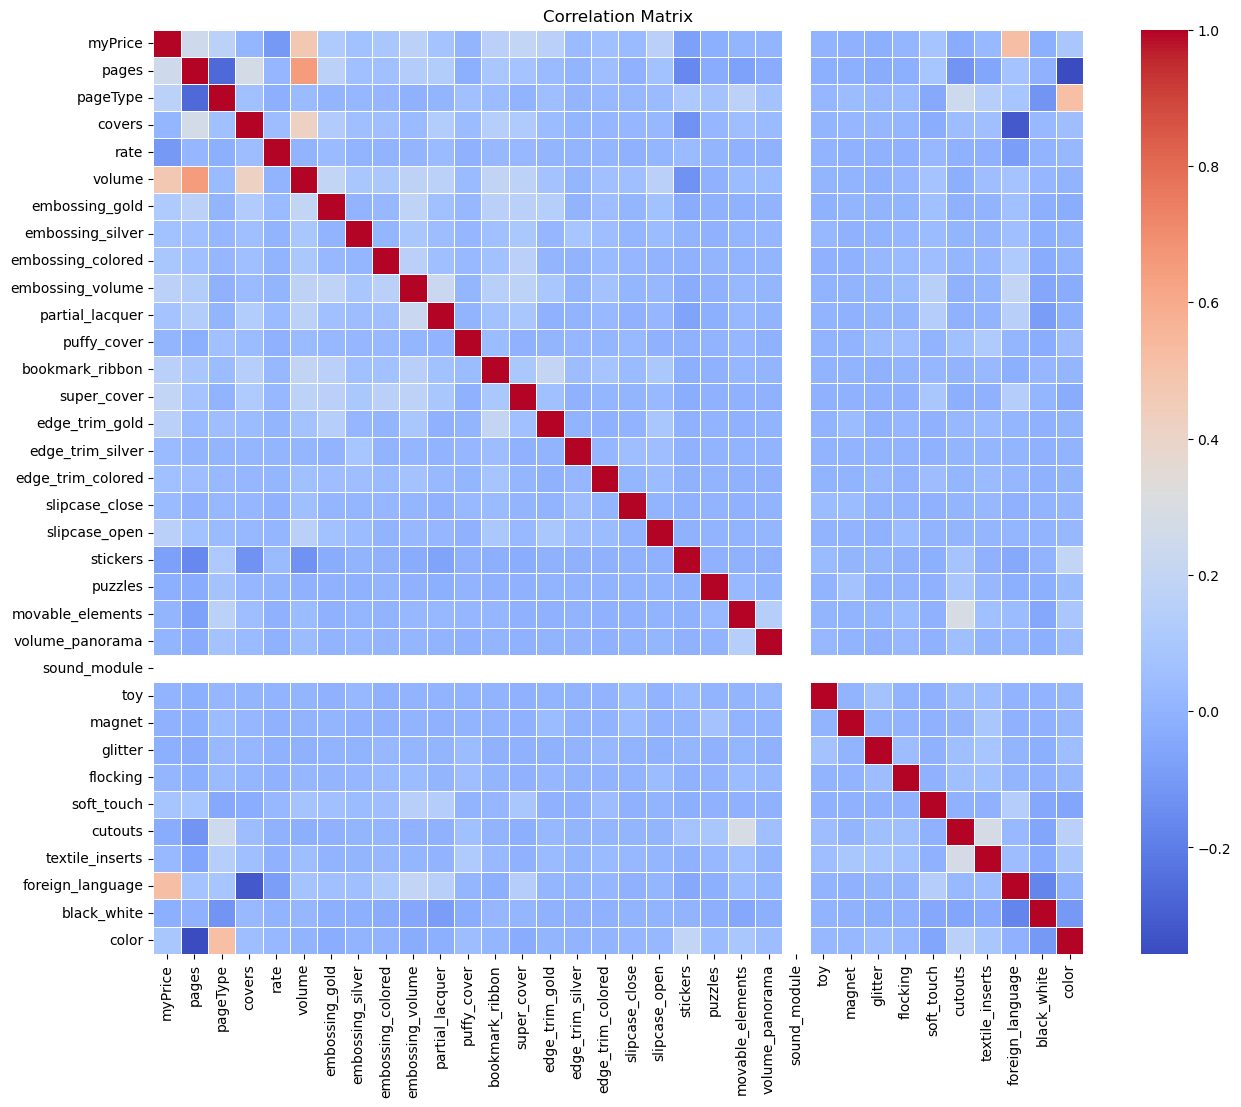

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построим тепловую карту корреляций
plt.figure(figsize=(15, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Как видно из матрицы корреляций, мы может избавитсья от полностью пустого параметра 'sound_module' 
# (обнулился, т.к. мы дропали некоторые пустые строки для полей в силу их малой незаполненности)
df = df.drop(columns=['sound_module'])

In [6]:
# Теперь найдем максимальные элементы в матрице (не учитывая диагональные и дублирующиеся данные)

# Преобразуем матрицу в формат long
correlation_pairs = correlation_matrix.unstack()

# Убираем дубли (нижний треугольник и диагональ)
correlation_pairs = correlation_pairs.reset_index()
correlation_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
correlation_pairs = correlation_pairs[correlation_pairs['Variable1'] != correlation_pairs['Variable2']]
correlation_pairs['Pair'] = correlation_pairs[['Variable1', 'Variable2']].apply(frozenset, axis=1)
correlation_pairs = correlation_pairs.drop_duplicates('Pair').drop(columns='Pair')

# Сортируем по убыванию корреляции
top_10_correlations = correlation_pairs.sort_values(by='Correlation', ascending=False).head(10)

# Выводим результат
print(top_10_correlations)

             Variable1         Variable2  Correlation
39               pages            volume     0.654479
31             myPrice  foreign_language     0.522521
101           pageType             color     0.517418
5              myPrice            volume     0.471289
107             covers            volume     0.415888
743   movable_elements           cutouts     0.287476
1016           cutouts   textile_inserts     0.275956
37               pages            covers     0.272274
1              myPrice             pages     0.252241
97            pageType           cutouts     0.246228


In [7]:
# Сохранение обновленных очищенных данных в CSV файл
df.to_csv('cleaned_labirint_dataset.csv', index=False)

In [8]:
df.columns

Index(['myPrice', 'pages', 'pageType', 'covers', 'rate', 'volume',
       'embossing_gold', 'embossing_silver', 'embossing_colored',
       'embossing_volume', 'partial_lacquer', 'puffy_cover', 'bookmark_ribbon',
       'super_cover', 'edge_trim_gold', 'edge_trim_silver',
       'edge_trim_colored', 'slipcase_close', 'slipcase_open', 'stickers',
       'puzzles', 'movable_elements', 'volume_panorama', 'toy', 'magnet',
       'glitter', 'flocking', 'soft_touch', 'cutouts', 'textile_inserts',
       'foreign_language', 'black_white', 'color'],
      dtype='object')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 587
[LightGBM] [Info] Number of data points in the train set: 77732, number of used features: 30
[LightGBM] [Info] Start training from score 919.781699


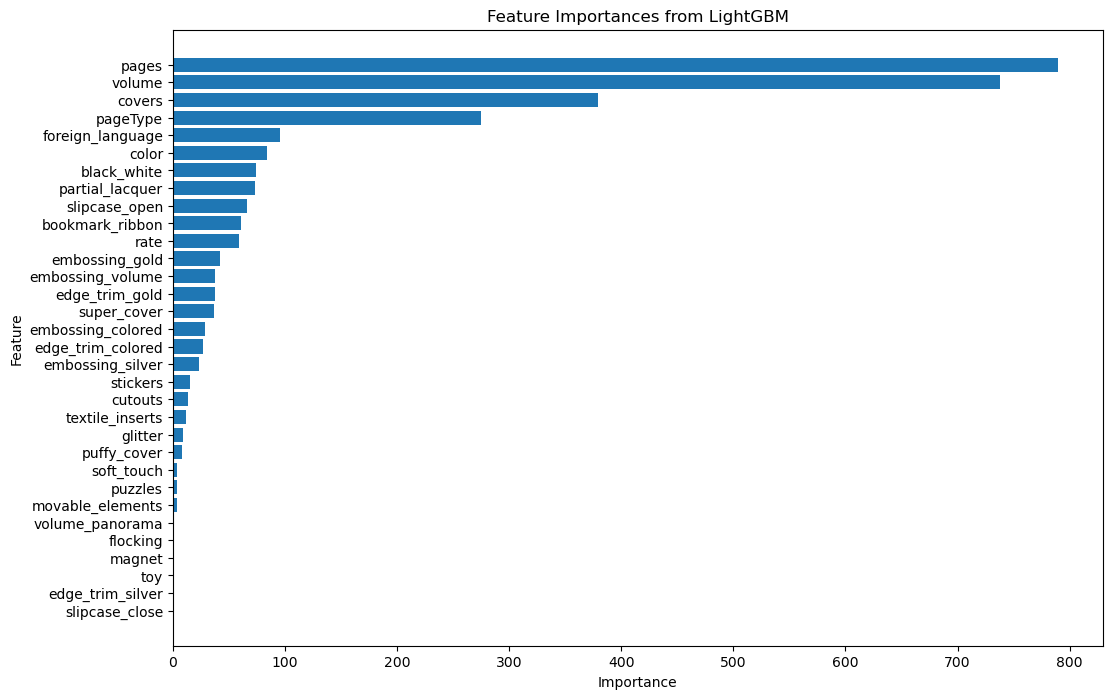

              Feature  Importance
0               pages         790
4              volume         738
2              covers         379
1            pageType         275
29   foreign_language          96
31              color          84
30        black_white          74
9     partial_lacquer          73
17      slipcase_open          66
11    bookmark_ribbon          61
3                rate          59
5      embossing_gold          42
8    embossing_volume          38
13     edge_trim_gold          38
12        super_cover          37
7   embossing_colored          29
15  edge_trim_colored          27
6    embossing_silver          23
18           stickers          15
27            cutouts          14
28    textile_inserts          12
24            glitter           9
10        puffy_cover           8
26         soft_touch           4
19            puzzles           4
20   movable_elements           4
21    volume_panorama           1
25           flocking           0
23            

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('cleaned_labirint_dataset.csv')

# Разделение данных на признаки и целевую переменную
X = df.drop(columns=['myPrice'])
y = df['myPrice']

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение LightGBM
model = LGBMRegressor(objective='regression', random_state=42)
model.fit(X_train, y_train)

# Получение важности признаков
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from LightGBM')
plt.gca().invert_yaxis()
plt.show()

# Вывод таблицы важности признаков
print(feature_importance_df)

In [10]:
# Фильтрация признаков с Importance > 15
selected_features = feature_importance_df[feature_importance_df['Importance'] > 20]['Feature'].tolist()

# Добавление целевой переменной
selected_features.append('myPrice')

# Фильтрация DataFrame
df_filtered = df[selected_features]

# Сохранение обновленного датасета
df_filtered.to_csv('cleaned_labirint_dataset.csv', index=False)

2. Построим модель для предсказания цены

In [11]:
# Основные библиотеки
import pandas as pd
import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Модуль для визуализации прогресса
from tqdm.notebook import tqdm

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Машинное обучение
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Загрузка данных
df = pd.read_csv("cleaned_labirint_dataset.csv")

# Логарифмируем целевую переменную
y = np.log1p(df['myPrice'])
X = df.drop(columns=["myPrice"])

# Разделение данных
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Масштабирование непрерывных признаков
continuous_cols = ["pages", "volume"]
scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_val[continuous_cols] = scaler.transform(X_val[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

# Создание Dataset и DataLoader
class BookDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_dataset = BookDataset(X_train, y_train)
val_dataset = BookDataset(X_val, y_val)
test_dataset = BookDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Модель
class AdvancedPriceRegressor(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedPriceRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        
        self.fc_out = nn.Linear(128, 1)

        self.residual = nn.Linear(input_dim, 1)

    def forward(self, x):
        residual = self.residual(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        
        x = self.fc_out(x)
        return x + residual

# Инициализация модели
model = AdvancedPriceRegressor(input_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
scaler = GradScaler()

# TensorBoard
writer = SummaryWriter(log_dir="C:/temp/Project")

# Early Stopping
patience = 10
best_loss = float('inf')
trigger_count = 0

for epoch in range(300):
    model.train()
    total_train_loss = 0
    
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        with autocast():
            preds = model(batch_X)
            loss = criterion(preds, batch_y)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            preds = model(val_X)
            loss = criterion(preds, val_y)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    
    # Логируем Learning Rate
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar("LearningRate", current_lr, epoch)
    
    # Шаг планировщика обучения
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        trigger_count = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        trigger_count += 1
        if trigger_count >= patience:
            print("Early stopping triggered.")
            break

writer.close()

Using device: cuda


C:\Anaconda3\envs\work\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Мой компьютер\AppData\Local\Temp\ipykernel_25844\821018081.py:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1:   0%|          | 0/1215 [00:00<?, ?it/s]

C:\Users\Мой компьютер\AppData\Local\Temp\ipykernel_25844\821018081.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 1.1414
Validation Loss: 0.3783


Epoch 2:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.4694
Validation Loss: 0.5213


Epoch 3:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.4326
Validation Loss: 0.3342


Epoch 4:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.4048
Validation Loss: 0.3605


Epoch 5:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3897
Validation Loss: 0.3501


Epoch 6:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3757
Validation Loss: 0.3372


Epoch 7:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3680
Validation Loss: 0.3427


Epoch 8:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3581
Validation Loss: 0.3146


Epoch 9:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3553
Validation Loss: 0.3118


Epoch 10:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3504
Validation Loss: 0.3129


Epoch 11:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3473
Validation Loss: 0.3265


Epoch 12:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3428
Validation Loss: 0.3189


Epoch 13:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3393
Validation Loss: 0.3155


Epoch 14:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3377
Validation Loss: 0.3347


Epoch 15:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3353
Validation Loss: 0.3396


Epoch 16:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3307
Validation Loss: 0.3100


Epoch 17:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3249
Validation Loss: 0.3201


Epoch 18:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3243
Validation Loss: 0.3151


Epoch 19:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3246
Validation Loss: 0.3278


Epoch 20:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3230
Validation Loss: 0.3070


Epoch 21:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3215
Validation Loss: 0.3026


Epoch 22:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3207
Validation Loss: 0.3103


Epoch 23:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3209
Validation Loss: 0.3125


Epoch 24:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3171
Validation Loss: 0.3055


Epoch 25:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3167
Validation Loss: 0.3015


Epoch 26:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3173
Validation Loss: 0.3450


Epoch 27:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3170
Validation Loss: 0.3008


Epoch 28:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3163
Validation Loss: 0.3022


Epoch 29:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3146
Validation Loss: 0.3011


Epoch 30:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3150
Validation Loss: 0.3060


Epoch 31:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3131
Validation Loss: 0.3068


Epoch 32:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3109
Validation Loss: 0.2981


Epoch 33:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3128
Validation Loss: 0.2984


Epoch 34:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3111
Validation Loss: 0.3022


Epoch 35:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3108
Validation Loss: 0.3012


Epoch 36:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3093
Validation Loss: 0.2994


Epoch 37:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3088
Validation Loss: 0.2957


Epoch 38:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3092
Validation Loss: 0.2976


Epoch 39:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3070
Validation Loss: 0.2958


Epoch 40:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3084
Validation Loss: 0.3032


Epoch 41:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3075
Validation Loss: 0.2989


Epoch 42:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3077
Validation Loss: 0.2955


Epoch 43:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3072
Validation Loss: 0.3032


Epoch 44:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3067
Validation Loss: 0.2995


Epoch 45:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3061
Validation Loss: 0.2943


Epoch 46:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3051
Validation Loss: 0.2983


Epoch 47:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3043
Validation Loss: 0.2956


Epoch 48:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3047
Validation Loss: 0.2968


Epoch 49:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3026
Validation Loss: 0.2934


Epoch 50:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3033
Validation Loss: 0.3002


Epoch 51:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3026
Validation Loss: 0.2962


Epoch 52:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3021
Validation Loss: 0.2941


Epoch 53:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3021
Validation Loss: 0.2937


Epoch 54:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3013
Validation Loss: 0.2963


Epoch 55:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.3017
Validation Loss: 0.3287


Epoch 56:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2993
Validation Loss: 0.2979


Epoch 57:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2985
Validation Loss: 0.2907


Epoch 58:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2974
Validation Loss: 0.2963


Epoch 59:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2968
Validation Loss: 0.2910


Epoch 60:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2970
Validation Loss: 0.2920


Epoch 61:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2968
Validation Loss: 0.2909


Epoch 62:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2963
Validation Loss: 0.2917


Epoch 63:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2970
Validation Loss: 0.2893


Epoch 64:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2971
Validation Loss: 0.3029


Epoch 65:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2956
Validation Loss: 0.2926


Epoch 66:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2968
Validation Loss: 0.2906


Epoch 67:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2946
Validation Loss: 0.2931


Epoch 68:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2953
Validation Loss: 0.2902


Epoch 69:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2948
Validation Loss: 0.2889


Epoch 70:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2955
Validation Loss: 0.2912


Epoch 71:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2955
Validation Loss: 0.2930


Epoch 72:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2948
Validation Loss: 0.2940


Epoch 73:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2939
Validation Loss: 0.2978


Epoch 74:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2942
Validation Loss: 0.2906


Epoch 75:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2944
Validation Loss: 0.2889


Epoch 76:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2938
Validation Loss: 0.2888


Epoch 77:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2945
Validation Loss: 0.2879


Epoch 78:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2945
Validation Loss: 0.2951


Epoch 79:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2945
Validation Loss: 0.2906


Epoch 80:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2935
Validation Loss: 0.2903


Epoch 81:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2937
Validation Loss: 0.2882


Epoch 82:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2938
Validation Loss: 0.2889


Epoch 83:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2933
Validation Loss: 0.2888


Epoch 84:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2914
Validation Loss: 0.2890


Epoch 85:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2907
Validation Loss: 0.3035


Epoch 86:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2907
Validation Loss: 0.3601


Epoch 87:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2911
Validation Loss: 0.2877


Epoch 88:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2921
Validation Loss: 0.2893


Epoch 89:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2913
Validation Loss: 0.2883


Epoch 90:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2903
Validation Loss: 0.2883


Epoch 91:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2905
Validation Loss: 0.3369


Epoch 92:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2903
Validation Loss: 0.2916


Epoch 93:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2898
Validation Loss: 0.2896


Epoch 94:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2892
Validation Loss: 0.2883


Epoch 95:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2891
Validation Loss: 0.2873


Epoch 96:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2888
Validation Loss: 0.2870


Epoch 97:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2896
Validation Loss: 0.2917


Epoch 98:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2898
Validation Loss: 0.2873


Epoch 99:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2892
Validation Loss: 0.3329


Epoch 100:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2890
Validation Loss: 0.2900


Epoch 101:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2893
Validation Loss: 0.2873


Epoch 102:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2896
Validation Loss: 0.2890


Epoch 103:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2881
Validation Loss: 0.2906


Epoch 104:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2888
Validation Loss: 0.2885


Epoch 105:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2884
Validation Loss: 0.2879


Epoch 106:   0%|          | 0/1215 [00:00<?, ?it/s]

Train Loss: 0.2888
Validation Loss: 0.2905
Early stopping triggered.


3. Протестируем на тестовой выборке

In [12]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_preds, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        y_preds.extend(preds)
        y_true.extend(y_batch.cpu().numpy())

mae = mean_absolute_error(y_true, y_preds)
mse = mean_squared_error(y_true, y_preds)
r2 = r2_score(y_true, y_preds)

print(f"Test MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

Test MAE: 0.3991, MSE: 0.2929, R²: 0.7366


C:\Users\Мой компьютер\AppData\Local\Temp\ipykernel_25844\3492870941.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


In [13]:
print(model)

AdvancedPriceRegressor(
  (fc1): Linear(in_features=18, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (relu3): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (residual): Linear(in_features=18, out_features=1, bias=True)
)
